In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/tmp/ipykernel_1586/1799943160.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


# Exercise 1



<img src="./images/01.png" width=800>

In [ ]:
import os
import mlflow
os.environ['MLFLOW_TRACKING_URI'] = './mlruns'
mlflow.set_tracking_uri(os.environ.get('MLFLOW_TRACKING_URI'))

In [ ]:
mlflow.set_experiment('Exercise_1')
# mlflow.start_run(run_name='Exercise_1')

2025/04/06 10:25:39 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/773631873264077024', creation_time=1743922539674, experiment_id='773631873264077024', last_update_time=1743922539674, lifecycle_stage='active', name='Exercise_1', tags={}>

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torchinfo import summary
from utils import train_simple_network, plot_data_and_predictions, plot_loss, set_seed

/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


<Axes: >

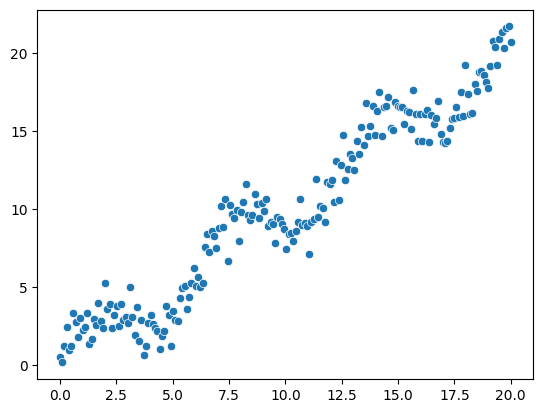

In [ ]:
set_seed(42)
X = np.linspace(0, 20, 200)
Y = X + 2 * np.sin(X) + np.random.normal(size = X.shape)
sns.scatterplot(x=X, y=Y)

In [ ]:
set_seed(42)
class SimpleRegressionDataset(Dataset):
    def __init__(self, X , Y):
        self.X = X.reshape(-1, 1)
        self.Y = Y.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        Y_tensor = torch.tensor(self.Y[idx], dtype=torch.float32)
        return X_tensor, Y_tensor

training_loader = DataLoader(SimpleRegressionDataset(X, Y), shuffle=True)

In [ ]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)


with mlflow.start_run(nested=True, run_name='without_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32)).numpy()
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch: 100%|██████████| 50/50 [00:31<00:00,  1.61it/s]
2025/04/06 10:26:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:27:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
print(loss[-1])    #This value represents the average loss for the mini-batches during the final epoch of training.
mean_squared_error(Y, Y_pred.ravel())   #This is calculated post-training using the entire dataset, without batch processing or sampling.

(1.9263681689828809, np.float64(3.2934337754510623))

### Scaling Input

In [ ]:
from sklearn.preprocessing import StandardScaler

input_scaler = StandardScaler()
scaled_X = input_scaler.fit_transform(X.reshape(-1, 1))
training_loader = DataLoader(SimpleRegressionDataset(scaled_X, Y), shuffle=True)
# mse = train_simple_network(model, loss_func, training_loader, epochs=100)

In [ ]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)

with mlflow.start_run(nested=True, run_name='input_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]
2025/04/06 10:28:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:28:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:28:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


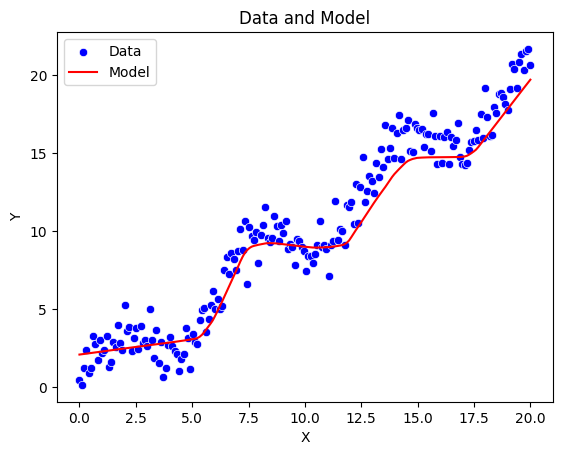

In [ ]:
with torch.no_grad():
    Y_pred = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()
plot_data_and_predictions(X, Y, Y_pred)

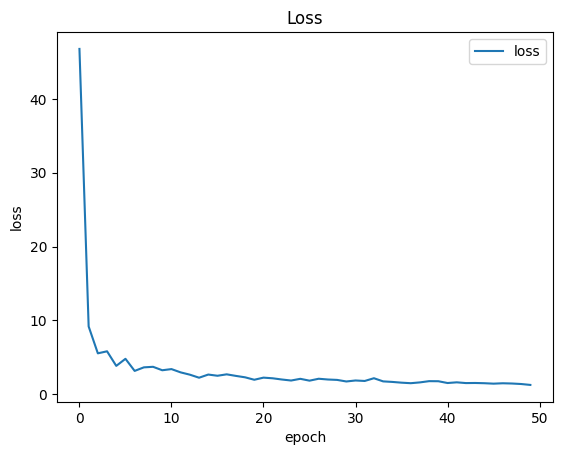

In [ ]:
plot_loss(loss)

In [ ]:
print(loss[-1])    #This value represents the average loss for the mini-batches during the final epoch of training.
mean_squared_error(Y, Y_pred.ravel())   #This is calculated post-training using the entire dataset, without batch processing or sampling.

1.2727373226408962


np.float64(1.9578474999968185)

### Scaling output

In [ ]:
from sklearn.preprocessing import StandardScaler

output_scaler = StandardScaler()
scaled_Y = output_scaler.fit_transform(Y.reshape(-1, 1))


training_loader = DataLoader(SimpleRegressionDataset(X, scaled_Y), shuffle=True)
# mse = train_simple_network(model, loss_func, training_loader, epochs=100)

In [ ]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)

with mlflow.start_run(nested=True, run_name='output_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred_scaled = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32)).numpy()
    Y_pred = output_scaler.inverse_transform(Y_pred_scaled)
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]
2025/04/06 10:29:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:29:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:29:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Axes: >

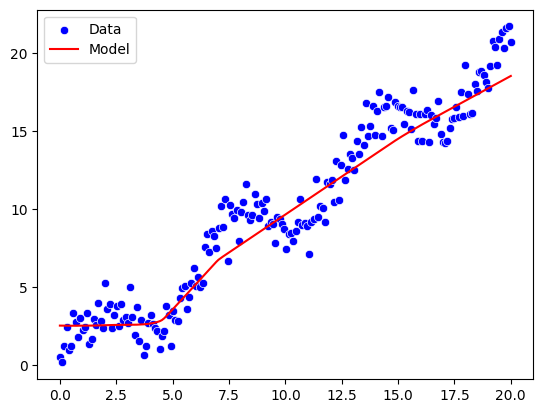

In [ ]:
with torch.no_grad():
    Y_pred_scaled = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32)).numpy()

Y_pred = output_scaler.inverse_transform(Y_pred_scaled)

plot_data_and_predictions(X, Y, Y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y, Y_pred.ravel()), mean_squared_error(scaled_Y, Y_pred_scaled.ravel()) 

(np.float64(2.9571463943845604), np.float64(0.08577446697027132))

### Scaling Input and output

In [ ]:
from sklearn.preprocessing import StandardScaler

out_in_scaler = StandardScaler()
scaled_X = out_in_scaler.fit_transform(X.reshape(-1, 1))
scaled_Y = out_in_scaler.fit_transform(Y.reshape(-1, 1))


training_loader = DataLoader(SimpleRegressionDataset(scaled_X, scaled_Y), shuffle=True)
# mse = train_simple_network(model, loss_func, training_loader, epochs=100)

In [ ]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)

with mlflow.start_run(nested=True, run_name='input_output_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred_scaled = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()
    Y_pred = output_scaler.inverse_transform(Y_pred_scaled)
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]
2025/04/06 10:31:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:31:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:31:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Axes: >

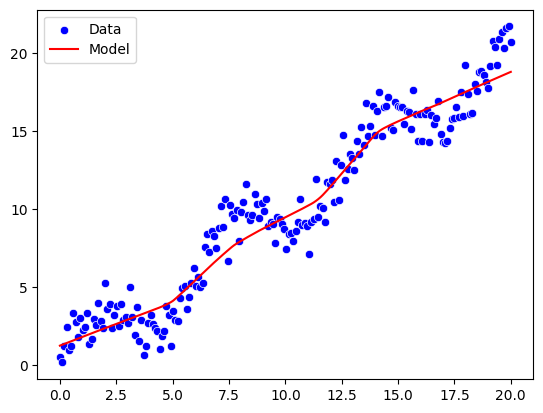

In [ ]:
with torch.no_grad():
    Y_pred_scaled = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()

Y_pred = output_scaler.inverse_transform(Y_pred_scaled)
plot_data_and_predictions(X, Y, Y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y, Y_pred.ravel()), mean_squared_error(scaled_Y, Y_pred_scaled.ravel())

(np.float64(1.9855890171986135), np.float64(0.057593641620202585))

### Results from MLflow

mse:

<img src='./images/mse_entire_dataset.png' width=800>

training loss:

<img src='./images/train_loss.png' width=800>

<img src='./images/train_loss_output_scaling.png' width=800>